In [1]:
import numpy as np
%matplotlib inline

# NOTE: we are storing y's as 1's or 0's but still doing the mean stuff correctly
def get_sample(n, mean, var):
    x_sample = []
    y_sample = []
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.normal(-mean, var)
        else:
            x = np.random.normal(mean, var)
        x_sample.append(x)
        y_sample.append(y)
    return np.array(x_sample), np.array(y_sample)

import seaborn as sns
import matplotlib.pyplot as plt


def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_sample(50000, 2, 1)
sample = list(zip(X, y))
class_two, class_neg_two = split_by_class(sample)

X, y = get_sample(50000, 4, 1)
sample = list(zip(X, y))
class_four, class_neg_four = split_by_class(sample)

X, y = get_sample(50000, 0, 1)
sample = list(zip(X, y))
class_zero, class_neg_zero = split_by_class(sample)

X, y = get_sample(50000, 8, 1)
sample = list(zip(X, y))
class_eight, class_neg_eight = split_by_class(sample)


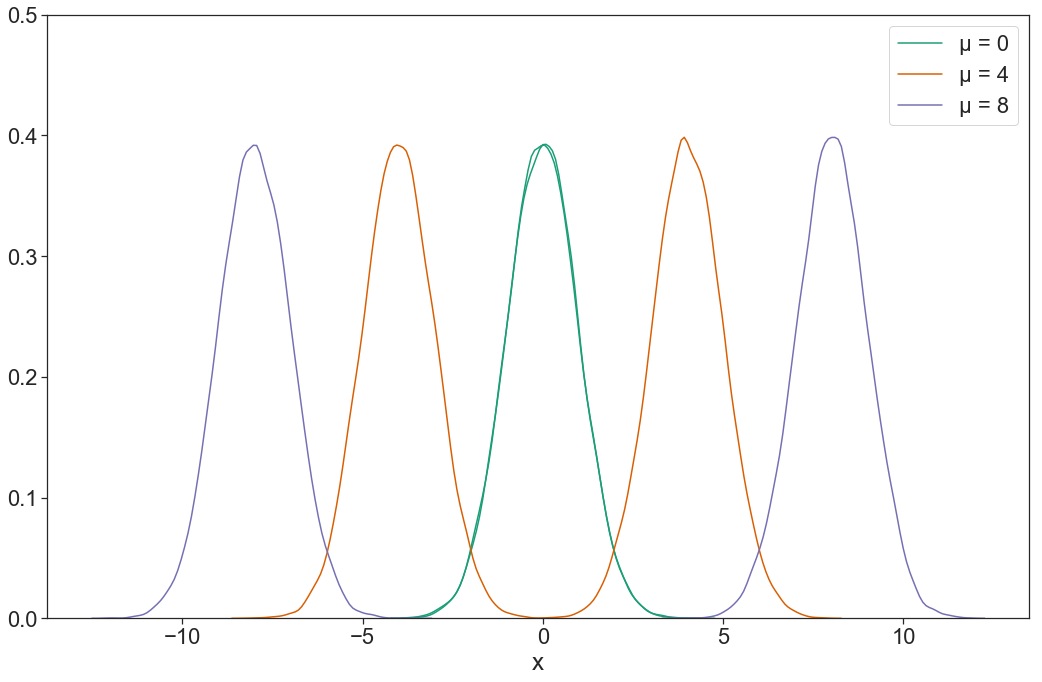

In [2]:
sns.set(font_scale = 2)
sns.set_style("ticks")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['figure.figsize'] = [15, 10]
plt.figure()

sns.distplot(list(zip(*class_zero))[0], hist=False, color = "#1b9e77", label = u'\u03bc = 0')
sns.distplot(list(zip(*class_neg_zero))[0], hist=False, color = "#1b9e77")

sns.distplot(list(zip(*class_four))[0], hist=False, color = "#d95f02", label = u'\u03bc = 4')
sns.distplot(list(zip(*class_neg_four))[0], hist=False, color = "#d95f02")
plt.tight_layout()
sns.distplot(list(zip(*class_eight))[0], hist=False, color = "#7570b3", label = u'\u03bc = 8')
sns.distplot(list(zip(*class_neg_eight))[0], hist=False, color = "#7570b3")
plt.ylim(ymax = .5)
plt.xlabel("x")
plt.legend()
plt.tight_layout()

In [49]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math

np.warnings.filterwarnings('ignore')


X, y = get_sample(1000, 0, 1)
X = X.reshape(-1, 1)

def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    print(probs)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)


rf_entropy_estimate_bagging(X, y, 500, .32)


[[0.46203387 0.53796613]
 [0.59010854 0.40989146]
 [0.50131728 0.49868272]
 ...
 [0.58104328 0.41895672]
 [0.42691867 0.57308133]
 [0.53570164 0.46429836]]


0.6824448369245736

In [46]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy import sparse
import math

np.warnings.filterwarnings('ignore')

class CEF:
    def __init__(self, n_estimators = 200, 
                 max_samples = .5, 
                 depth = 30, 
                 min_samples_leaf = 1, 
                 max_features = None):
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.depth = depth
        self.min_samples_leaf = min_samples_leaf
        if max_features == None:
            self.max_features = math.ceil(int(math.sqrt(X.shape[1])))
        else:
            self.max_features = max_features
        self.model = None
        self.tree_counts = []
        
    def fit(self, X, y):
        self.model = BaggingClassifier(DecisionTreeClassifier(max_depth=self.depth, min_samples_leaf=self.min_samples_leaf, max_features=self.max_features), 
                              n_estimators=self.n_estimators, 
                              max_samples=self.max_samples, 
                              bootstrap=True)
        self.model.fit(X, y)
        for tree in self.model:
            prob_indices = _generate_unsampled_indices(tree.random_state, len(X))
            np.random.shuffle(prob_indices)
            # get all node counts
            node_counts = tree.tree_.n_node_samples
            # get probs for eval samples
            posterior_class_counts = np.zeros((len(node_counts), self.model.n_classes_))
            for prob_index in prob_indices:
                posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
            self.tree_counts.append(sparse.csr_matrix(posterior_class_counts))
            
    def predict_proba(self, X):
        posterior_prob = np.zeros((X.shape[0], self.model.n_classes_))
        for i in range(X.shape[0]):
            x = X[i].item()
            tree_idx = 0
            counts = np.zeros(self.model.n_classes_)
            total = 0
            for tree in self.model:
                index = tree.apply(x)
                count = self.tree_counts[tree_idx][index, :].toarray().flatten()
                if np.count_nonzero(count) == 1:
                    sum_count = np.sum(count)
                    count[count == 0] = sum_count*1/(np.sum(count)*self.model.n_classes_)
                    count[count != 0] = sum_count*(1 - (self.model.n_classes_ - 1)/(np.sum(count)*self.model.n_classes_))
                counts += count
                tree_idx += 1
            posterior_prob[i] = counts/np.sum(counts)
        return posterior_prob
        

In [47]:
X, y = get_sample(1000, 0, 1)
X = X.reshape(-1, 1)
cef = CEF()
cef.fit(X, y)
posterior = cef.predict_proba(X)
posterior

array([[0.58684454, 0.41315546],
       [0.46330603, 0.53669397],
       [0.54928401, 0.45071599],
       ...,
       [0.50118914, 0.49881086],
       [0.61198278, 0.38801722],
       [0.50572695, 0.49427305]])

In [48]:
print(np.mean(posterior, axis = 0))

[0.50586389 0.49413611]
